### Import all required libraries

In [21]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from sklearn.preprocessing import LabelEncoder

### Explore dataset garbage_classification_12_classes

In [ ]:
dataset_path = os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42
EXCLUDED_CLASSES = ['clothes', 'shoes']

# Get the list of classes, excluding the specified ones
all_classes = sorted(os.listdir(dataset_path))
classes = [c for c in all_classes if c not in EXCLUDED_CLASSES]
print("Waste types (excluding clothes and shoes):", classes)

Waste types (excluding clothes and shoes): ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']


### Create Dataframe

In [3]:
metadata = []
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            metadata.append({"image_path": img_path, "class": class_name})

df_metadata = pd.DataFrame(metadata)

### Split data

In [4]:
# Split data
train_df, temp_df = train_test_split(df_metadata, test_size=0.2, random_state=SEED, stratify=df_metadata['class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['class'])

### ImageDataGenerator

In [5]:
# ImageDataGenerator for training with augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    seed=SEED,
    shuffle=True
)

# ImageDataGenerator for validation (only preprocessing)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    seed=SEED,
    shuffle=False
)

# ImageDataGenerator for test (only preprocessing)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=dataset_path,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    seed=SEED,
    shuffle=False
)

Found 6570 validated image filenames belonging to 10 classes.
Found 821 validated image filenames belonging to 10 classes.
Found 822 validated image filenames belonging to 10 classes.


### Training ResNet 50 model

In [6]:
# Load the pre-trained base model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# ModelCheckpoint to save the best model based on validation loss
checkpoint_filepath = 'best_model_10_classes.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss', 
    save_best_only=True,
    save_weights_only=False,
    mode='min', 
    verbose=1
)

callbacks_list = [early_stopping, lr_scheduler, model_checkpoint_callback]

# Training the model with generators
epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

# Evaluate the model on the test generator
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50
205/205 [==============================] - ETA: 0s - loss: 2.1801 - accuracy: 0.2560
Epoch 1: val_loss improved from inf to 2.20638, saving model to best_model_10_classes.h5
205/205 [==============================] - 247s 1s/step - loss: 2.1801 - accuracy: 0.2560 - val_loss: 2.2064 - val_accuracy: 0.1863 - lr: 1.0000e-04
Epoch 2/50
205/205 [==============================] - ETA: 0s - loss: 1.9708 - accuracy: 0.3243
Epoch 2: val_loss improved from 2.20638 to 2.19107, saving model to best_model_10_classes.h5
205/205 [==============================] - 262s 1s/step - loss: 1.9708 - accuracy: 0.3243 - val_loss: 2.1911 - val_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 3/50
205/205 [==============================] - ETA: 0s - loss: 1.9002 - accuracy: 0.3568
Epoch 3: val_loss improved from 2.19107 to 2.06147, saving model to best_model_10_classes.h5
205/205 [==============================] - 298s 1s/step - loss: 1.9002 - accuracy: 0.3568 - val_loss: 2.0615 - val_accuracy: 0.3313 - lr: 1

### Evaluating model

In [6]:
# Load the best saved model
best_model = load_model('best_model_10_classes.h5')

# Evaluate the model in the test generator
loss, accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report using test_generator
y_pred_probs = best_model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for i in range(test_generator.samples // BATCH_SIZE):
    _, labels = test_generator[i]
    y_true.extend(np.argmax(labels, axis=1))
y_true = np.array(y_true)

report = classification_report(y_true, y_pred, target_names=classes, zero_division=0)
print("Classification Report (Test Set):\n", report)

25/25 [==============================] - 28s 1s/step - loss: 1.5209 - accuracy: 0.5238
Test Loss: 1.5209
Test Accuracy: 0.5238
25/25 [==============================] - 28s 1s/step
Classification Report (Test Set):
               precision    recall  f1-score   support

     battery       0.63      0.76      0.69        94
  biological       0.71      0.56      0.62        98
 brown-glass       0.56      0.39      0.46        57
   cardboard       0.55      0.66      0.60        88
 green-glass       0.61      0.57      0.59        60
       metal       0.32      0.28      0.30        72
       paper       0.56      0.64      0.60       101
     plastic       0.34      0.42      0.38        83
       trash       0.52      0.47      0.49        70
 white-glass       0.39      0.34      0.36        77

    accuracy                           0.52       800
   macro avg       0.52      0.51      0.51       800
weighted avg       0.53      0.52      0.52       800



In [7]:
loss_val, accuracy_val = best_model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE, verbose=0)
print(f"Validation Loss: {loss_val:.4f}")
print(f"Validation Accuracy: {accuracy_val:.4f}")

y_pred_val_probs = best_model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
y_pred_val = np.argmax(y_pred_val_probs, axis=1)

y_true_val = []
for i in range(validation_generator.samples // BATCH_SIZE):
    _, labels = validation_generator[i]
    y_true_val.extend(np.argmax(labels, axis=1))
y_true_val = np.array(y_true_val)

report_val = classification_report(y_true_val, y_pred_val, target_names=classes, zero_division=0)
print("Classification Report (Validation Set):\n", report_val)

Validation Loss: 1.5295
Validation Accuracy: 0.5025
25/25 [==============================] - 30s 1s/step
Classification Report (Validation Set):
               precision    recall  f1-score   support

     battery       0.69      0.78      0.73        92
  biological       0.69      0.52      0.60        96
 brown-glass       0.53      0.51      0.52        59
   cardboard       0.47      0.55      0.51        86
 green-glass       0.57      0.34      0.43        61
       metal       0.36      0.33      0.35        75
       paper       0.52      0.58      0.55       104
     plastic       0.41      0.48      0.44        86
       trash       0.44      0.45      0.45        64
 white-glass       0.34      0.35      0.34        77

    accuracy                           0.50       800
   macro avg       0.50      0.49      0.49       800
weighted avg       0.51      0.50      0.50       800



In [8]:
train_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
train_generator_eval = train_datagen_eval.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    seed=SEED,
    shuffle=False  
)

loss_train, accuracy_train = best_model.evaluate(train_generator_eval, steps=train_generator_eval.samples // BATCH_SIZE, verbose=0)
print(f"Train Loss: {loss_train:.4f}")
print(f"Train Accuracy: {accuracy_train:.4f}")

y_pred_train_probs = best_model.predict(train_generator_eval, steps=train_generator_eval.samples // BATCH_SIZE)
y_pred_train = np.argmax(y_pred_train_probs, axis=1)
y_true_train = train_generator_eval.classes[:len(y_pred_train)]
report_train = classification_report(y_true_train, y_pred_train, target_names=classes, zero_division=0)
print("Classification Report (Training Set):\n", report_train)

Found 6570 validated image filenames belonging to 10 classes.
Train Loss: 1.4225
Train Accuracy: 0.5351
205/205 [==============================] - 247s 1s/step
Classification Report (Training Set):
               precision    recall  f1-score   support

     battery       0.67      0.76      0.71       756
  biological       0.73      0.60      0.66       788
 brown-glass       0.54      0.52      0.53       484
   cardboard       0.51      0.64      0.57       712
 green-glass       0.57      0.40      0.47       502
       metal       0.41      0.34      0.37       614
       paper       0.54      0.58      0.56       838
     plastic       0.40      0.45      0.42       692
       trash       0.55      0.59      0.57       556
 white-glass       0.39      0.35      0.37       618

    accuracy                           0.54      6560
   macro avg       0.53      0.52      0.52      6560
weighted avg       0.54      0.54      0.53      6560



### Training Loss and Accuracy

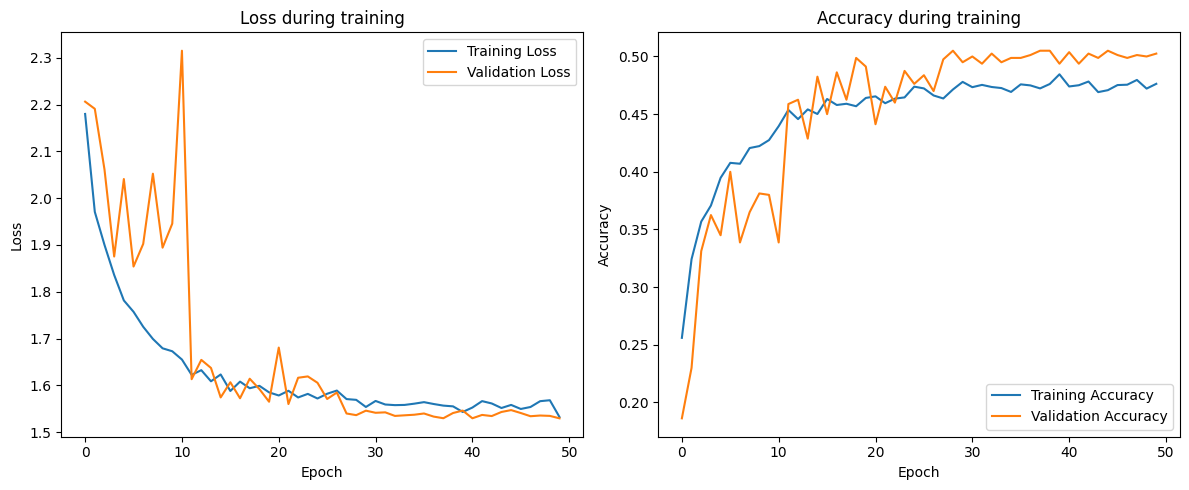

In [19]:
# Loss and accuracy visualization during the training model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Confusion matrix

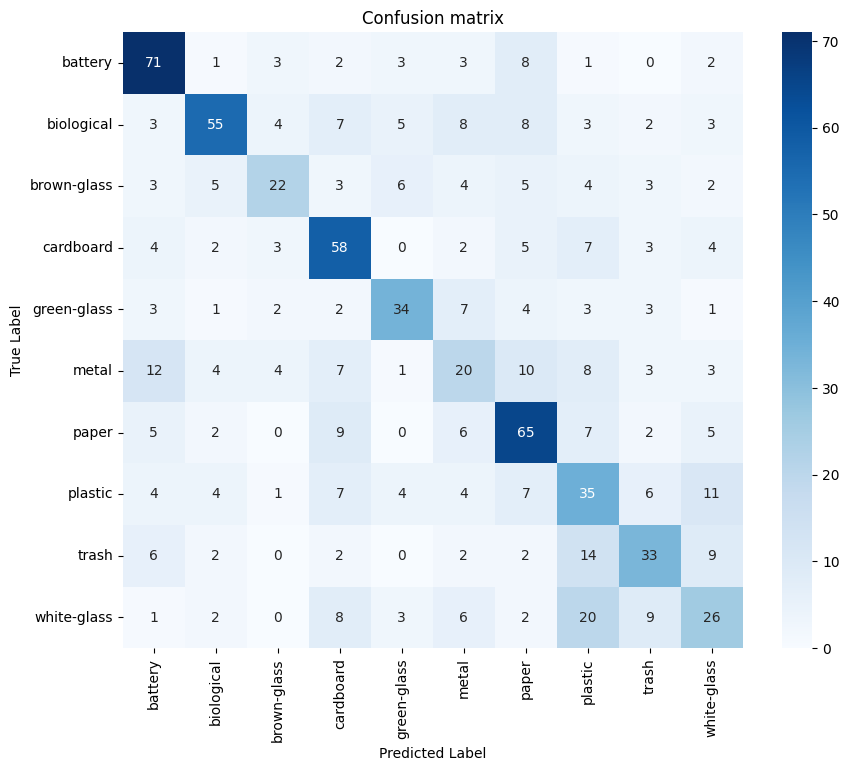

In [18]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion matrix')
plt.show()

Found 822 validated image filenames belonging to 10 classes.
25/25 [==============================] - 33s 1s/step


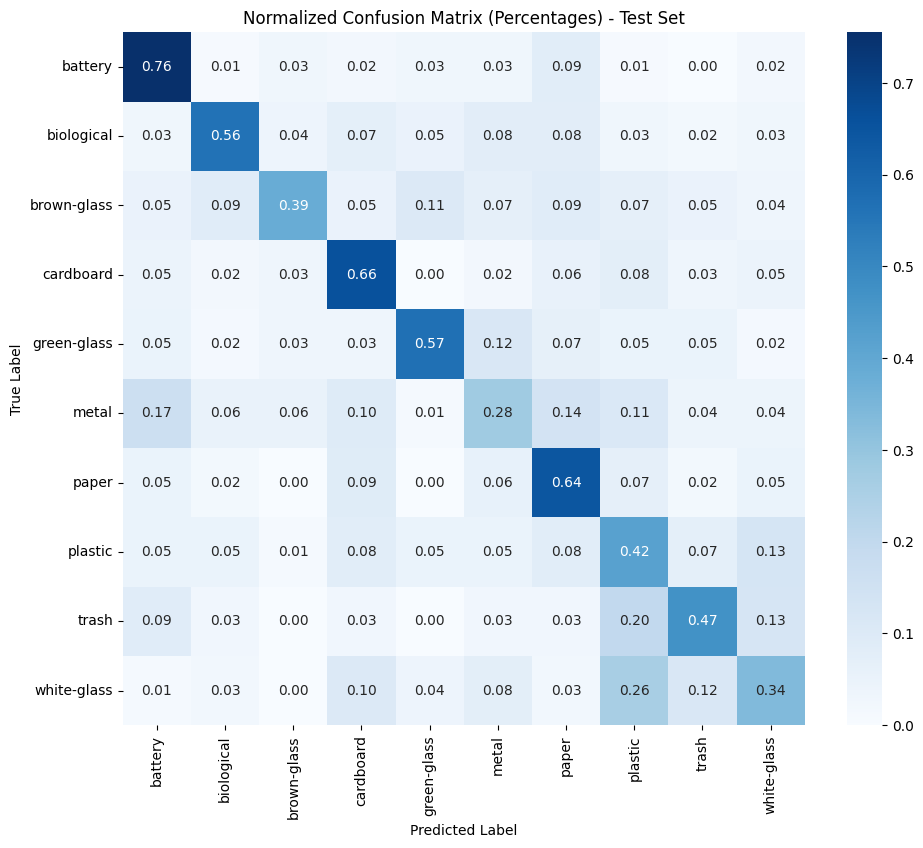

In [ ]:
classes = ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass'] 

# ImageDataGenerator for Test Set Evaluation
test_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator_eval = test_datagen_eval.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes,
    seed=SEED,
    shuffle=False
)

# Obtain Predictions and True Tags for the Test Set
y_pred_test_probs = best_model.predict(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE)
y_pred_test = np.argmax(y_pred_test_probs, axis=1)
y_true_test = test_generator_eval.classes[:len(y_pred_test)]

# Calculate and Display the Normalized Confusion Matrix
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_normalized_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(11, 9))
sns.heatmap(cm_normalized_test, annot=True, fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Percentages) - Test Set')
plt.show()

### Mapping and evaluating to 7 classes

In [ ]:
original_classes = ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']
class_mapping = {
    'biological': 'trash',
    'brown-glass': 'glass',
    'battery': 'battery',
    'cardboard': 'cardboard',
    'green-glass': 'glass',
    'metal': 'metal',
    'paper': 'paper',
    'plastic': 'plastic',
    'trash': 'trash',
    'white-glass': 'glass'
}
mapped_classes = sorted(list(set(class_mapping.values())))
num_mapped_classes = len(mapped_classes)

# ImageDataGenerator for Test Set Evaluation
test_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator_eval = test_datagen_eval.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=original_classes, 
    seed=SEED,
    shuffle=False
)

# Evaluation of the Model in the Test Set (before mapping)
loss_before, accuracy_before = best_model.evaluate(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss (before mapping): {loss_before:.4f}")
print(f"Test Accuracy (before mapping): {accuracy_before:.4f}")

# Obtain Predictions and True Tags for the Test Set
y_pred_probs = best_model.predict(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE)
y_pred_original = np.argmax(y_pred_probs, axis=1)
y_true_original = test_generator_eval.classes[:len(y_pred_original)]

# Mapping True and Predicted Tags to New Classes
y_mapped_true = np.array([mapped_classes.index(class_mapping[original_classes[label]]) for label in y_true_original])
y_mapped_pred = np.array([mapped_classes.index(class_mapping[original_classes[label]]) for label in y_pred_original])

# Evaluation of the Model in the Test Set (after mapping)
from sklearn.metrics import accuracy_score
accuracy_after = accuracy_score(y_mapped_true, y_mapped_pred)
print(f"Test Accuracy (after mapping): {accuracy_after:.4f}")

# Ranking Report (after mapping)
report_mapped = classification_report(y_mapped_true, y_mapped_pred, target_names=mapped_classes, zero_division=0)
print("Classification Report (Test Set - after mapping):\n", report_mapped)

Found 822 validated image filenames belonging to 10 classes.
25/25 [==============================] - 34s 1s/step - loss: 1.5209 - accuracy: 0.5238
Test Loss (before mapping): 1.5209
Test Accuracy (before mapping): 0.5238
25/25 [==============================] - 36s 1s/step
Test Accuracy (after mapping): 0.5463
Classification Report (Test Set - after mapping):
               precision    recall  f1-score   support

     battery       0.63      0.76      0.69        94
   cardboard       0.55      0.66      0.60        88
       glass       0.60      0.49      0.54       194
       metal       0.32      0.28      0.30        72
       paper       0.56      0.64      0.60       101
     plastic       0.34      0.42      0.38        83
       trash       0.65      0.55      0.59       168

    accuracy                           0.55       800
   macro avg       0.52      0.54      0.53       800
weighted avg       0.55      0.55      0.54       800



Found 822 validated image filenames belonging to 10 classes.
25/25 [==============================] - 27s 1s/step


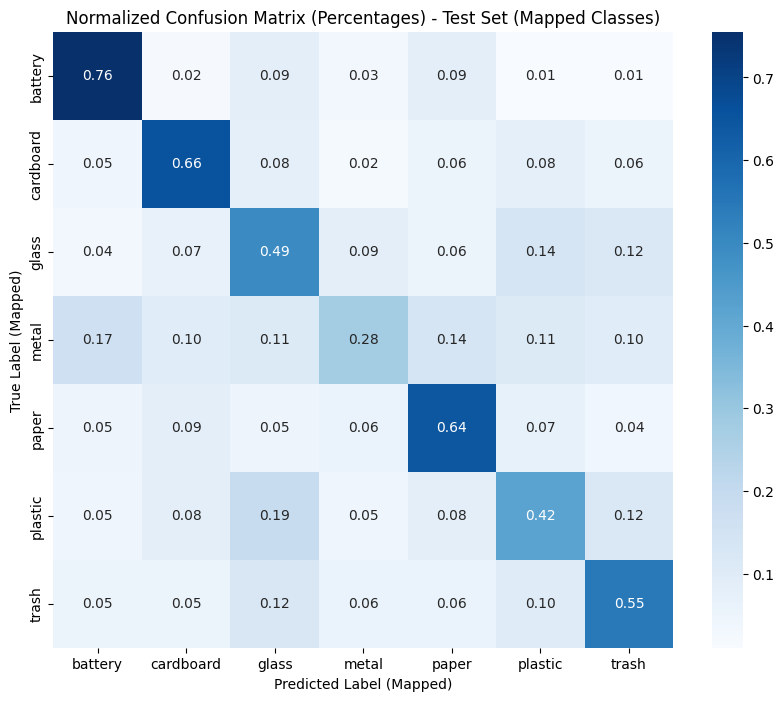

In [ ]:
# Calculate the Confusion Matrix (with the mapped classes)
cm_mapped = confusion_matrix(y_mapped_true, y_mapped_pred)

# Normalize the Confusion Matrix to show Percentages
cm_normalized_mapped = cm_mapped.astype('float') / cm_mapped.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized_mapped, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=mapped_classes, yticklabels=mapped_classes)
plt.xlabel('Predicted Label (Mapped)')
plt.ylabel('True Label (Mapped)')
plt.title('Normalized Confusion Matrix (Percentages) - Test Set (Mapped Classes)')
plt.show()

### Mapping and evaluating to 4 classes

In [ ]:
original_classes = ['battery', 'biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']
class_mapping3 = {
    'brown-glass': 'glass',
    'green-glass': 'glass',
    'white-glass': 'glass',
    'cardboard': 'paper',
    'paper': 'paper',
    'metal': 'plastic',
    'plastic': 'plastic',
    'battery': 'other',         
    'biological': 'other',      
    'trash': 'other'
}
mapped3_classes = sorted(list(set(class_mapping3.values())))
num_mapped3_classes = len(mapped3_classes)

# ImageDataGenerator for Test Set Evaluation
test_datagen_eval = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
test_generator_eval = test_datagen_eval.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=original_classes,
    seed=SEED,
    shuffle=False
)

# Evaluation of the Model in the Test Set
loss_before, accuracy_before = best_model.evaluate(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss (before mapping): {loss_before:.4f}")
print(f"Test Accuracy (before mapping): {accuracy_before:.4f}")

# Obtain Predictions and True labels for the Test Set
y_pred_probs = best_model.predict(test_generator_eval, steps=test_generator_eval.samples // BATCH_SIZE)
y_pred_original = np.argmax(y_pred_probs, axis=1)
y_true_original = test_generator_eval.classes[:len(y_pred_original)]

# Mapping True and Predicted Tags to New Classes
y_mapped3_true = np.array([mapped3_classes.index(class_mapping3[original_classes[label]]) for label in y_true_original])
y_mapped3_pred = np.array([mapped3_classes.index(class_mapping3[original_classes[label]]) for label in y_pred_original])

# Evaluation of the Model in the Test Set (after mapping)
from sklearn.metrics import accuracy_score
accuracy_after = accuracy_score(y_mapped3_true, y_mapped3_pred)
print(f"Test Accuracy (after mapping): {accuracy_after:.4f}")

# Ranking Report (after mapping)
report_mapped3 = classification_report(y_mapped3_true, y_mapped3_pred, target_names=mapped3_classes, zero_division=0)
print("Classification Report (Test Set - after mapping):\n", report_mapped3)

Found 822 validated image filenames belonging to 10 classes.
25/25 [==============================] - 33s 1s/step - loss: 1.5209 - accuracy: 0.5238
Test Loss (before mapping): 1.5209
Test Accuracy (before mapping): 0.5238
25/25 [==============================] - 36s 1s/step
Test Accuracy (after mapping): 0.5913
Classification Report (Test Set - after mapping):
               precision    recall  f1-score   support

       glass       0.60      0.49      0.54       194
       other       0.68      0.66      0.67       262
       paper       0.62      0.72      0.67       189
     plastic       0.41      0.43      0.42       155

    accuracy                           0.59       800
   macro avg       0.58      0.58      0.57       800
weighted avg       0.59      0.59      0.59       800



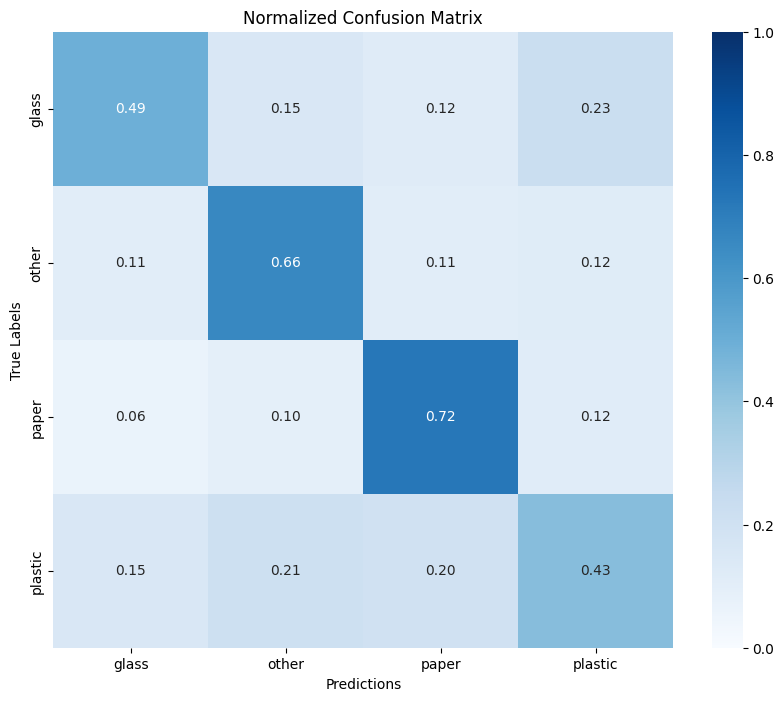

In [ ]:
# Normalized Confounding Matrix
cm = confusion_matrix(y_mapped3_true, y_mapped3_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm_normalized, 
                      annot=True, 
                      fmt='.2f',  
                      cmap='Blues', 
                      xticklabels=mapped3_classes, 
                      yticklabels=mapped3_classes,
                      vmin=0, 
                      vmax=1)  

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.show()

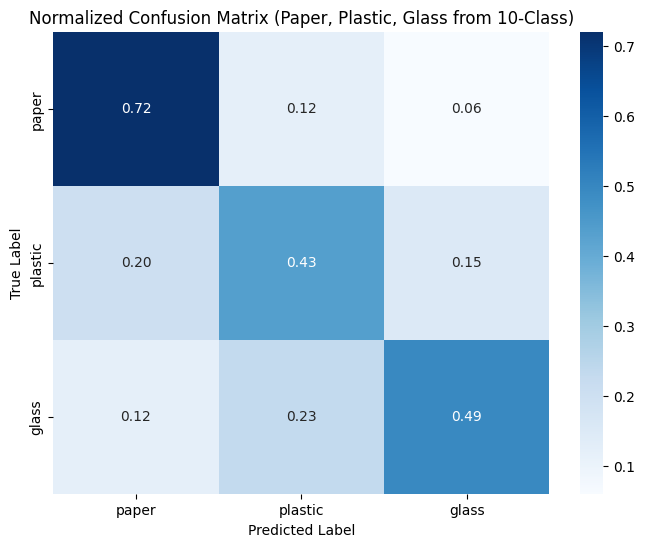

In [4]:
classes = ['paper', 'plastic', 'glass']


personalized_matrix = np.array([
    
    [0.72 / (0.06 + 0.10 + 0.72 + 0.12),  
     0.12 / (0.06 + 0.10 + 0.72 + 0.12),  
     0.06 / (0.06 + 0.10 + 0.72 + 0.12)], 
    
    [0.20 / (0.15 + 0.21 + 0.20 + 0.43),  
     0.43 / (0.15 + 0.21 + 0.20 + 0.43),  
     0.15 / (0.15 + 0.21 + 0.20 + 0.43)], 
  
    [0.12 / (0.49 + 0.15 + 0.12 + 0.23), 
     0.23 / (0.49 + 0.15 + 0.12 + 0.23), 
     0.49 / (0.49 + 0.15 + 0.12 + 0.23)]  
])

plt.figure(figsize=(8, 6))
sns.heatmap(personalized_matrix,
            annot=True,
            fmt=".2f",
            cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Paper, Plastic, Glass from 10-Class)')
plt.show()

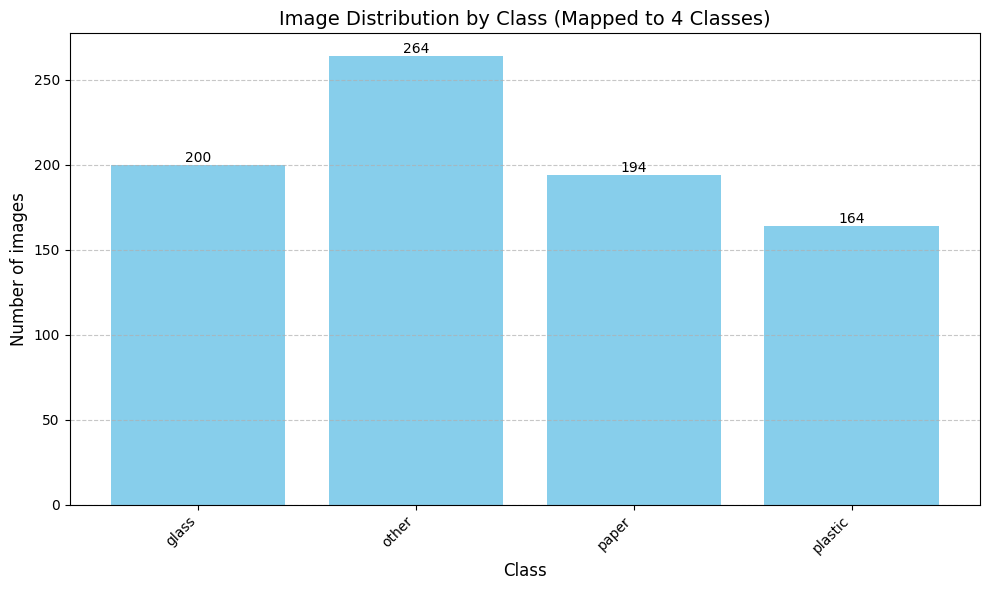

In [ ]:
# Map the original classes to the new 4 classes in the DataFrame
test_df['mapped_class'] = test_df['class'].map(class_mapping3)

# Count the number of images per mapped class
class_counts = test_df['mapped_class'].value_counts().reindex(mapped3_classes, fill_value=0)

plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')

plt.title('Image Distribution by Class (Mapped to 4 Classes)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje X
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout() 
plt.show()

### Tableau

In [22]:
def save_training_history_with_epoch(history: History, filename='training_history.csv'):
    history_dict = history.history
    epoch_count = len(history_dict.get('loss', []))  # Get the number of epochs from the history

    # Create an 'epoch' list
    epochs = list(range(1, epoch_count + 1))

    # Add the 'epoch' list to the history dictionary
    history_dict['epoch'] = epochs

    history_df = pd.DataFrame(history_dict)
    history_df.to_csv(filename, index=False)

In [ ]:
def save_training_history_with_epoch(history: History, filename='training_history.csv'):
    history_dict = history.history
    epoch_count = len(history_dict.get('loss', []))  # Get the number of epochs from the history

    # Create an 'epoch' list
    epochs = list(range(1, epoch_count + 1))

    # Add the 'epoch' list to the history dictionary
    history_dict['epoch'] = epochs

    history_df = pd.DataFrame(history_dict)
    history_df.to_csv(filename, index=False)

In [ ]:
save_training_history_with_epoch(history)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

In [ ]:
cm_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
cm_normalized_df = pd.DataFrame(cm_normalized, index=classes, columns=classes)
cm_normalized_df.to_csv('confusion_matrix_normalized.csv')